In [1]:
%load_ext autoreload
%autoreload 2
import os
os.chdir('/home/svcl-oowl/brandon/research/CVPR_2021_REFINE/sil_consistent_at_inference')
print(os.getcwd())

/home/svcl-oowl/brandon/research/CVPR_2021_REFINE/sil_consistent_at_inference


In [2]:
import pprint
import pickle

import torch
from torch.nn import functional as F
import torch.optim as optim
from tqdm.autonotebook import tqdm
import pandas as pd
import numpy as np

from pose_pred import dataset
from pose_pred.pose_pred_network import PoseNetwork

In [3]:
class_name = "02691156"
batch_size = 32
epochs = 35
lr = 0.00001
weight_decay = 0.0

#input_mesh_dir = "../occupancy_networks/out/pytorch3d_renders_training/{}/generation/meshes".format(class_name)
input_img_dir = "data/input_images/pytorch3d_shapenet_renders_training/{}/rgba".format(class_name)
pose_path = "../occupancy_networks/out/pytorch3d_renders_training/{}/generation/meshes/rec_camera_params.pt".format(class_name)
train_partition_file = "data_prep_tools/adv_refine_training_partitions/{}_train.lst".format(class_name)
val_partition_file = "data_prep_tools/adv_refine_training_partitions/{}_val.lst".format(class_name)

cfg = {"input_img_dir":input_img_dir, "pose_path": pose_path, "train_partition_file":train_partition_file,  "val_partition_file":val_partition_file}
device = torch.device("cuda:0")

In [4]:
with open(cfg["train_partition_file"], 'r') as f:
    train_partition_instances = f.read().split('\n')
training_dataset = dataset.PosePredDataset(cfg, train_partition_instances)
training_dataloader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, num_workers=2, shuffle=True, drop_last=True)

with open(cfg["val_partition_file"], 'r') as f:
    val_partition_instances = f.read().split('\n')
val_dataset = dataset.PosePredDataset(cfg, val_partition_instances)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=2, shuffle=False, drop_last=True)

Filtered based on specified instances, from 4045 -> 2589.
Filtered based on specified instances, from 4045 -> 647.


In [5]:
pose_net = PoseNetwork(cfg, device).to(device)
optimizer = optim.Adam(pose_net.parameters(), lr=lr, weight_decay=weight_decay)

In [6]:
training_df = pd.DataFrame()
val_df = pd.DataFrame()
for epoch_idx in tqdm(range(epochs)):
    for batch_i, batch in enumerate(tqdm(training_dataloader)):
        optimizer.zero_grad()
        pose_net.train()
        
        pred_pose = pose_net(batch)
        
        gt_pose = batch["pose"].to(device)
        loss = F.mse_loss(pred_pose[:,1], gt_pose[:,1])
        loss.backward()
        optimizer.step()
        
        curr_df_dict = {"epoch":epoch_idx+(batch_i/len(training_dataloader)), "loss":loss.item()}
        training_df = training_df.append(curr_df_dict, ignore_index=True)
    
    
    # evaluating on validation set
    with torch.no_grad():
        avg_val_loss = 0.0
        for batch_i, batch in enumerate(tqdm(val_dataloader)):
            pose_net.eval()
            pred_pose = pose_net(batch)
        
            gt_pose = batch["pose"].to(device)
            loss = F.mse_loss(pred_pose[:,1], gt_pose[:,1])
            avg_val_loss += loss.item()
        avg_val_loss = avg_val_loss / len(val_dataloader)
        val_df = val_df.append({"epoch":epoch_idx, "loss":avg_val_loss}, ignore_index=True)

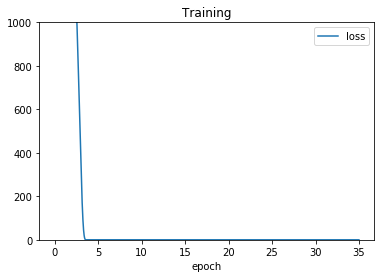

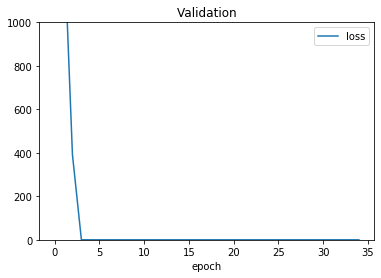

In [10]:
upper_lim = 1000
training_df.plot.line(x="epoch", y="loss", ylim=[0,upper_lim], title="Training")
val_df.plot.line(x="epoch", y="loss", ylim=[0,upper_lim], title="Validation")

In [11]:
with torch.no_grad():
    for batch_i, batch in enumerate(val_dataloader):
        pose_net.eval()
        pred_pose = pose_net(batch)

        gt_pose = batch["pose"].to(device)
        print(pred_pose[:4,:])
        print(gt_pose[:4,:])
        break
        

tensor([[ 6.5819, 39.9834, 14.0342],
        [ 6.5798, 39.9708, 14.0299],
        [ 6.5851, 40.0023, 14.0409],
        [ 6.5810, 39.9780, 14.0323]], device='cuda:0')
tensor([[125.9526,  40.0000,   1.3333],
        [302.5276,  40.0000,   1.3333],
        [137.1988,  40.0000,   0.8205],
        [181.8660,  40.0000,   1.0769]], device='cuda:0')


In [12]:
torch.set_printoptions(sci_mode=False)
with torch.no_grad():
    for batch_i, batch in enumerate(training_dataloader):
        pose_net.eval()
        pred_pose = pose_net(batch)

        gt_pose = batch["pose"].to(device)
        print(pred_pose[:4,:])
        print(gt_pose[:4,:])
        break

tensor([[ 6.5790, 39.9658, 14.0281],
        [ 6.5791, 39.9663, 14.0283],
        [ 6.5823, 39.9855, 14.0350],
        [ 6.5813, 39.9797, 14.0330]], device='cuda:0')
tensor([[  4.3612,  40.0000,   1.3333],
        [255.6475,  40.0000,   1.3333],
        [177.0566,  40.0000,   1.3333],
        [ 43.4251,  40.0000,   1.2692]], device='cuda:0')
